## Notebook to adjust PlanetScope images using the estimated surface reflectance of snow

Rainey Aberle

Summer 2022

__To-Do:__
- option to remove intermediate files (i.e., if hillshade correction and radiometric adjustment are selected, remove hs-corrected file)
- option to filter images with clipped bands

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rasterio.features
from shapely.geometry import Polygon
import shapely.geometry
from scipy.interpolate import interp2d
from scipy import stats
import time
import rasterio as rio
import geopandas as gpd
import sys
import ee

### Authenticate and initialize Google Earth Engine (GEE)

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### 1. Define paths in directory, snow-covered area (SCA), and settings

In [3]:
# -----Define paths in directory
site_name = 'SCascade'
# path to planet-snow/ directory
base_path = '/Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/'
# path to stitched PlanetScope images
im_path = base_path+'../study-sites/'+site_name+'/imagery/PlanetScope/stitched/'
# output folder
out_path = im_path+'../adjusted-filtered/'
# AOI shapefile full path in directory
AOI_fn = base_path+'../../GIS_data/RGI_outlines/'+site_name+'_RGI.shp'

# -----Determine settings
plot_results = True # = True to plot corrected images
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max blue SR < 0.8

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

### 2. Load DEM, AOI, and PlanetScope images. Create polygon representing approximate year-round snow-covered area (SCA) based on elevations distribution.

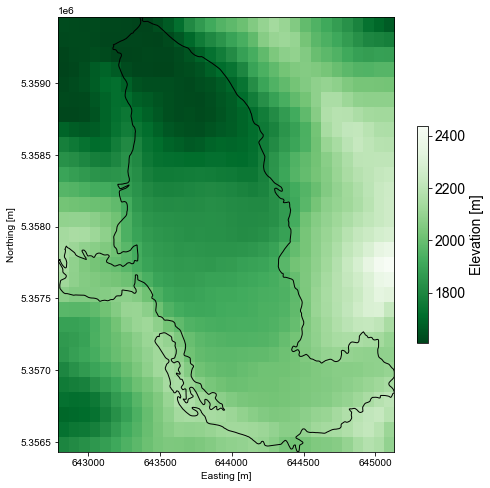

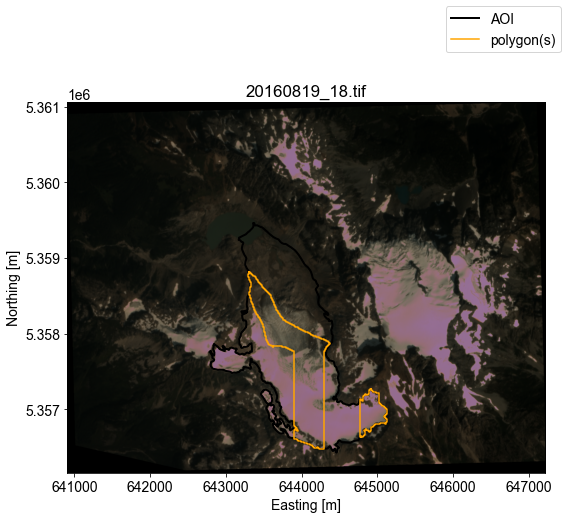

In [4]:
# -----Load AOI as gpd.GeoDataFrame
AOI = gpd.read_file(AOI_fn)

# -----Load DEM
os.chdir(im_path) 
im_fns = glob.glob('*.tif') # read image filenames
im_fns.sort() # sort chronologically
DEM, DEM_x, DEM_y, AOI_UTM = f.query_GEE_for_DEM(AOI, im_path, im_fns)

# -----Create a polygon of the top 10th percentile elevations within the AOI
polygon, im_fn, im, r, g, b, im_x, im_y = f.create_top_elev_AOI_poly(AOI_UTM, im_path, im_fns, DEM, DEM_x, DEM_y)

# -----Plot
fig = plt.figure(figsize=(8,8))
plt.imshow(np.dstack([r, g, b]), extent=(np.min(im_x), np.max(im_x), np.min(im_y), np.max(im_y)))
plt.plot(*AOI_UTM.geometry[0].exterior.xy, color='black', linewidth=2, label='AOI')
count=0
for geom in polygon.geoms:    
    xs, ys = geom.exterior.xy    
    if count==0:
        plt.plot(xs, ys, color='orange', label='polygon(s)')
    else:
        plt.plot(xs, ys, color='orange', label='_nolegend_')
    count+=1
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.title(im_fn)
fig.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [6]:
from scipy.stats import iqr

os.chdir(im_path)
for i in range(0,len(im_fns)):
    # define image filename
    im_fn = im_fns[i]
    # open image
    im = rio.open(im_fn)
    # mask the image using AOI geometry
    mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                   im.read(1).shape,
                                   im.transform,
                                   all_touched=False,
                                   invert=False)
    # check if any image values exist within AOI
    if (0 in mask.flatten()):
        break

# -----Get image band shape and define image coordinates
b = im.read(1).astype(float)
g = im.read(2).astype(float)
r = im.read(3).astype(float)
nir = im.read(4).astype(float)
if (np.nanmax(b) > 1e3):
    im_scalar = 10000 # scalar multiplier for image reflectance values
    b = b / im_scalar
    g = g / im_scalar
    r = r / im_scalar
    nir = nir / im_scalar
# define coordinates grid
im_x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
im_y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

# -----Create mask from AOI on image grid
mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                       b.shape,
                                       im.transform,
                                       all_touched=False,
                                       invert=False)
# -----Regrid DEM to image coordinates
f_DEM = interp2d(DEM_x, DEM_y, DEM)
DEM_regrid = f_DEM(im_x, im_y)

# -----Mask DEM outside the AOI and the bottom percentile of elevations
DEM_regrid_AOImasked = np.where(mask==0, DEM_regrid, np.nan)
DEM_P = np.nanmedian(DEM_regrid_AOImasked) + iqr(DEM_regrid_AOImasked, rng=(30,70), nan_policy='omit')
DEM_regrid_AOImasked_Pmasked = np.where(DEM_regrid_AOImasked > DEM_P, DEM_regrid_AOImasked, np.nan)
mask = np.where(~np.isnan(DEM_regrid_AOImasked_Pmasked), 1, 0)


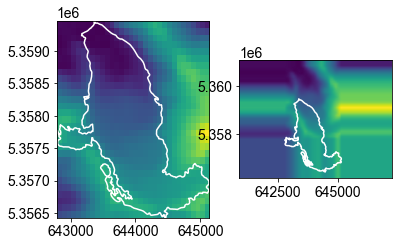

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(DEM, extent=(np.min(DEM_x), np.max(DEM_x), np.min(DEM_y), np.max(DEM_y)))
AOI_UTM.exterior.plot(ax=ax1, color='white')
ax2.imshow(DEM_regrid, extent=(np.min(im_x), np.max(im_x), np.min(im_y), np.max(im_y)))
AOI_UTM.exterior.plot(ax=ax2, color='white')

plt.show()

### 3. Loop through images

In [ ]:
# -----Start timer
t1 = time.monotonic()

# -----Loop through images
for im_fn in im_fns:
    
    # load image
    print('Image: ', im_fn)
    im = rio.open(im_fn)
    
    # adjust radiometry
    im_adj_fn = f.adjust_image_radiometry(im, im_fn, im_path, polygon, out_path, skip_clipped, plot_results)
    
    print('----------')
    print(' ')

# -----Stop timer
t2 = time.monotonic()
print('Time elapsed: ',str(round(t2-t1)/60),'minutes ')
    